In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
import pandas as pd
from arch import arch_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, r2_score, mean_absolute_error
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K


In [3]:
def read_data(window=22):
    price = pd.read_csv('dataset/kospi.csv')
    price = price.dropna()
    data = pd.DataFrame()
    data['Date'] = price['Date']
    data['Daily_trading_range'] = price['High'] - price['Low']
    data['Log_Volume_change'] = np.log((price['Volume'] / price['Volume'].shift(1))) * 100
    data['Daily_return'] = price['Close'].pct_change().dropna()
    data['Daily_log_return'] = np.log(price['Close'] / price['Close'].shift(1))
    data['Index'] = price['Close']

    data = data.dropna().reset_index(drop=True)

    volatility = data['Daily_log_return'].rolling(window=22).std() * np.sqrt(252)
    data['past_vol'] = volatility
    data = data.dropna().reset_index(drop=True)

    target = pd.DataFrame()
    target['Target'] = volatility[42:].reset_index(drop=True)
    target = target.dropna()

    return data, target

In [4]:
def evaluate(predict, target, title):
    # rev_pred = scaler.inverse_transform(predict)
    # rev_true = scaler.inverse_transform(target)
    print('--------'+title+'----------')
    testScore = mean_squared_error(predict, target)
    print("test Score: {score} MSE".format(score=testScore))
    root_testScore = mean_squared_error(y_pred=predict, y_true=target, squared=False)
    print("test Score: {score} RMSE".format(score=root_testScore))
    mape = mean_absolute_percentage_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAPE".format(score=mape))
    mae = mean_absolute_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAE".format(score=mae))
    # r2_test = r2_score(y_true=target, y_pred=predict)
    # print("test Score: {score} R2 score".format(score=r2_test))

In [5]:
def plot(predict, target, title, save=False):
    plt.plot(predict, label='predict')
    plt.plot(target, label='target')
    plt.title(title)
    plt.legend()
    if save:
        plt.savefig('images/'+title)
    plt.show()

In [6]:
def garch_evaluate(predict, target, title):
    print('--------'+title+'----------')
    testScore = mean_squared_error(predict, target)
    print("test Score: {score} MSE".format(score=testScore))
    root_testScore = mean_squared_error(y_pred=predict, y_true=target, squared=False)
    print("test Score: {score} RMSE".format(score=root_testScore))
    mape = mean_absolute_percentage_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAPE".format(score=mape))
    mae = mean_absolute_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAE".format(score=mae))

In [7]:
def create_gjr(data, target, window=22, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']])
    arr_target = np.array(target)
    gjr_pred = []
    mean_target = []
    target_window=22

    for i in range(len(target)-n_ahead+1):
        window_target = arr_target[i:i+n_ahead]
        mean_target.append(window_target.mean())
        train = logreturns[:i+window]*100
        gm = arch_model(train, p=1, q=1, o=1, dist='skewt')
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        gjr_pred.append(np.sqrt(pred.variance.values[-1, :].mean())* 0.01* np.sqrt(252))

    print('garch pred length: ', len(gjr_pred))
    print('target length: ', len(mean_target))
    title = 'GARCH prediction, window={}, n_ahead={}'.format(window, n_ahead)
    plot(gjr_pred, mean_target, title)
    gjr_pred = pd.DataFrame(gjr_pred, columns=['GJR'])
    print('-----GJR-GARCH estimation done-----')
    return gjr_pred, mean_target

In [8]:
def create_garch(data, target, window=22, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']])
    arr_target = np.array(target)
    garch_pred = []
    mean_target = []
    target_window = 22

    for i in range(len(target)-n_ahead+1):
        window_target = arr_target[i:i+n_ahead]
        mean_target.append(window_target.mean())
        train = logreturns[:i+window]*100
        gm = arch_model(train, p=2, q=3, dist='skewt')
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        garch_pred.append(np.sqrt(pred.variance.values[-1,:].mean())*0.01*np.sqrt(252))

    print('garch pred length: ', len(garch_pred))
    print('target length: ', len(mean_target))
    title = 'GARCH prediction, window={}, n_ahead={}'.format(window, n_ahead)
    plot(garch_pred, mean_target, title)
    garch_pred = pd.DataFrame(garch_pred, columns=['GARCH'])
    print('-----GARCH estimation done-----')
    return garch_pred, mean_target

In [9]:
def data_prep(data, target, split_index, status=0, n_ahead=1, window=22):
    extras=pd.DataFrame()

    data = data.drop(['Daily_return','Date'], axis=1)

    window = window
    n_ahead = n_ahead
    print(data.info())

    y_values = np.array(target)
    x_values = np.array(data)
    scaler = MinMaxScaler()
    scaled_x = scaler.fit_transform(x_values)
    scaled_y = scaler.fit_transform(y_values)

    if(status==1):
        extras['GARCH'] = data['GARCH'].dropna()

    elif(status==2):
        extras['GJR'] = data['GJR'].dropna()

    elif(status==3):
        extras['GARCH'] = data['GARCH'].dropna()
        extras['GJR'] = data['GJR'].dropna()
    x = np.array([])
    y = np.array([])

    for i in range(len(target)-n_ahead):
        # candidate = trainX[i - window:i, :trainX.shape[1]]
        candidate = scaled_x[i:i+window, :scaled_x.shape[1]]

        if(status==1):
            candidate[:,-1] = extras['GARCH'].iloc[i]
        elif(status==2):
            candidate[:,-1] = extras['GJR'].iloc[i]
        elif(status==3):
            candidate[:,-1] = extras['GARCH'].iloc[i]
            candidate[:,-2] = extras['GJR'].iloc[i]

        candidate = candidate.reshape(1, candidate.shape[0], candidate.shape[1])
        # y_candidate = trainY[i-window:i-window+n_ahead].reshape(1, trainY[i-window:i-window+n_ahead].shape[0], trainY[i-window:i-window+n_ahead].shape[1])
        y_candidate = scaled_y[i:i+n_ahead].reshape(1,scaled_y[i:i+n_ahead].shape[0], scaled_y[i:i+n_ahead].shape[1])

        if i==0:
            x = candidate
            y = y_candidate
            continue

        x = np.append(x, candidate, axis=0)
        y = np.append(y, y_candidate, axis=0)
        # ytrain.append(trainY[i:i+n_ahead])


    Xtrain, ytrain = (x[:split_index], y[:split_index])
    Xtest, ytest = (x[split_index:], y[split_index:])
    print(Xtrain.shape)
    print(ytrain.shape)
    print("-----")
    print(Xtest.shape)
    print(ytest.shape)
    return Xtrain, ytrain, Xtest, ytest, scaler

In [10]:
def create_lstm(output=1):
    model = Sequential()
    model.add(LSTM(units=64, input_dim=Xtrain.shape[2], return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.1))
    # model.add(LSTM(units=20, return_sequences=False))
    # model.add(Dropout(dropout3))
    # model.add(Dense(20, activation='tanh'))
    model.add(Dense(output))
    # model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    return model

In [11]:
def create_ann(output=1):
    model = Sequential()
    model.add(Flatten(input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(output))
    adam = Adam(learning_rate=0.001)
    model.compile(loss='mae', optimizer=adam)
    return model

In [12]:
def run_lstm(Xtrain, ytrain, Xtest, ytest, scaler):
    lstm = create_lstm(Xtrain)
    lstm_fit = lstm.fit(Xtrain, ytrain, batch_size=16, epochs=150)
    lstm_forecast = lstm.predict(Xtest)

    rev_forecast = scaler.inverse_transform(lstm_forecast)
    rev_ytest = scaler.inverse_transform(ytest)

    plot(rev_forecast, rev_ytest)
    evaluate(rev_forecast, rev_ytest, 'LSTM Evaluation')

In [13]:
def run_ann(Xtrain, ytrain, Xtest, ytest, scaler):
    model = create_ann(Xtrain)
    model_fit = model.fit(Xtrain, ytrain, batch_size=16, epochs=50)
    forecast = model.predict(Xtest)

    rev_forecast = scaler.inverse_transform(forecast)
    rev_ytest = scaler.inverse_transform(ytest)

    plt.plot(rev_forecast, color='red', label='forecast')
    plt.plot(rev_ytest, color='gold', label='target')
    plt.legend()
    plt.show()
    evaluate(rev_forecast, rev_ytest, 'GR-FNN evaluation')

In [14]:
data, target = read_data(22)

split_index = int(len(target)*0.8)
print('Split index: ',split_index)
print('Observations: ', len(data))

Split index:  1930
Observations:  2434


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2434 non-null   object 
 1   Daily_trading_range  2434 non-null   float64
 2   Log_Volume_change    2434 non-null   float64
 3   Daily_return         2434 non-null   float64
 4   Daily_log_return     2434 non-null   float64
 5   Index                2434 non-null   float64
 6   past_vol             2434 non-null   float64
dtypes: float64(6), object(1)
memory usage: 133.2+ KB


In [16]:
target.head(30)

,Target
0,0.194661
1,0.195336
2,0.198551
3,0.198867
4,0.205796
5,0.209859
6,0.198635
7,0.203040
8,0.203573
9,0.202901


In [24]:
window = 22
n_ahead=1
batch_size=32
epochs=100


/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/ch

garch pred length:  2413
target length:  2413
-----GARCH estimation done-----
garch pred length:  2413
target length:  2413
-----GJR-GARCH estimation done-----
         GARCH
0     0.224059
1     0.210866
2     0.204008
3     0.211587
4     0.216442
...        ...
2408  0.171022
2409  0.158641
2410  0.169131
2411  0.155327
2412  0.156898

[2413 rows x 1 columns]
           GJR
0     0.181932
1     0.190546
2     0.197364
3     0.175283
4     0.217853
...        ...
2408  0.141291
2409  0.137904
2410  0.133664
2411  0.129813
2412  0.127525

[2413 rows x 1 columns]


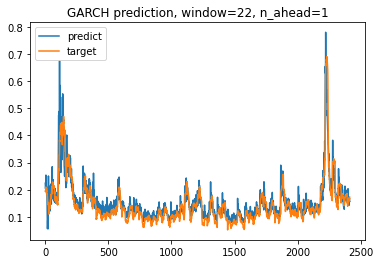

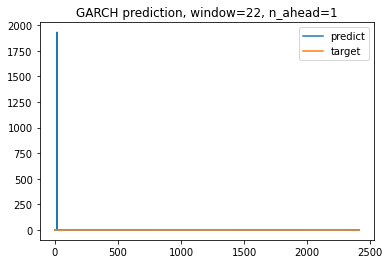

In [19]:
garch_estim, garch_y = create_garch(data, target, window=window, n_ahead=n_ahead)
gjr_estim, gjr_y = create_gjr(data, target, window=window, n_ahead=n_ahead)
print(garch_estim)
print(gjr_estim)

In [20]:
gjr_estim.iloc[18] = (gjr_estim.iloc[17]+gjr_estim.iloc[19])/2
data_g = data.copy()
data_g['GARCH'] = garch_estim['GARCH']
data_r = data.copy()
data_r['GJR'] = gjr_estim['GJR']
data_gr = data.copy()
data_gr['GJR'] = gjr_estim['GJR']
data_gr['GARCH'] = garch_estim['GARCH']

In [21]:
data.head()

,Date,Daily_trading_range,Log_Volume_change,Daily_return,Daily_log_return,Index,past_vol
0,2011-02-07,26.100098,-1.699365,0.004686,0.004675,2081.739990,0.118032
1,2011-02-08,25.719971,4.913988,-0.005784,-0.005800,2069.699951,0.117012
2,2011-02-09,39.820068,10.396094,-0.011654,-0.011722,2045.579956,0.123197
3,2011-02-10,34.569946,-7.281598,-0.018127,-0.018293,2008.500000,0.136661
4,2011-02-11,45.950073,2.392077,-0.015589,-0.015712,1977.189941,0.143134


In [51]:
Xtrain, ytrain, Xtest, ytest, scaler = data_prep(data_gr, target, split_index, status=3,n_ahead=n_ahead, window=window)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2434 non-null   float64
 1   Log_Volume_change    2434 non-null   float64
 2   Daily_log_return     2434 non-null   float64
 3   Index                2434 non-null   float64
 4   past_vol             2434 non-null   float64
 5   GJR                  2413 non-null   float64
 6   GARCH                2413 non-null   float64
dtypes: float64(7)
memory usage: 133.2 KB
None
(1930, 22, 7)
(1930, 1, 1)
-----
(482, 22, 7)
(482, 1, 1)


In [52]:
target

,Target
0,0.194661
1,0.195336
2,0.198551
3,0.198867
4,0.205796
...,...
2408,0.162242
2409,0.169021
2410,0.166023
2411,0.164762


In [53]:
model = create_lstm(output=n_ahead)
# model = create_ann(output=n_ahead)
for i in range(epochs):
    model.fit(Xtrain, ytrain, batch_size=batch_size, shuffle=False)
    model.reset_states()

61/61 [==============================] - 1s 21ms/step - loss: 0.0054

In [54]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(1930, 22, 7)
(1930, 1, 1)
(482, 22, 7)
(482, 1, 1)


In [55]:
forecast = model.predict(Xtest, batch_size=batch_size)

In [56]:
forecast = forecast.mean(axis=1).reshape(len(forecast),1)
ytest = ytest.mean(axis=1).reshape(len(ytest),1)

In [57]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

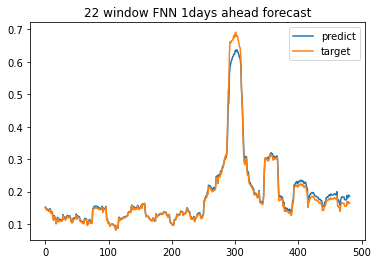

In [58]:
title = '{} window FNN {}days ahead forecast'.format(window, n_ahead)
plot(rev_forecast, rev_ytest, title, save=False)

In [59]:
evaluate(rev_forecast, rev_ytest, 'ANN')

--------ANN----------
test Score: 0.000170797850310817 MSE
test Score: 0.013068965158374897 RMSE
test Score: 0.03614439503501445 MAPE
test Score: 0.007666944152170917 MAE


In [387]:
garch_test = np.array(garch_estim.iloc[split_index:])
gjr_test = np.array(gjr_estim.iloc[split_index:])
stat_test = np.array(garch_y[split_index:]).reshape(len(garch_y[split_index:]), 1)

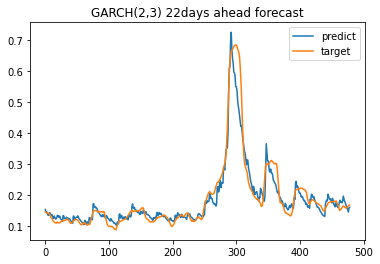

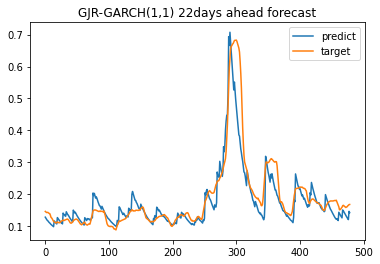

In [388]:
garch_title = 'GARCH(2,3) {}days ahead forecast'.format(window, n_ahead)
gjr_title = 'GJR-GARCH(1,1) {}days ahead forecast'.format(window,n_ahead)
plot(garch_test, stat_test, garch_title, True)
plot(gjr_test, stat_test, gjr_title, True)

In [389]:
garch_evaluate(garch_test, stat_test,'GARCH eval')
garch_evaluate(gjr_test, stat_test, 'GJR eval')

--------GARCH eval----------
test Score: 0.001017027671728955 MSE
test Score: 0.03189087129146764 RMSE
test Score: 0.09587475802659111 MAPE
test Score: 0.019259046970269707 MAE
--------GJR eval----------
test Score: 0.002287959383844524 MSE
test Score: 0.047832618408827715 RMSE
test Score: 0.12946400639510894 MAPE
test Score: 0.027640074496305008 MAE
